In [2]:
# System libraries:
%load_ext autoreload
import pandas as pd
import json
import nltk
import numpy as np
import os
import sys
from IPython.core.interactiveshell import InteractiveShell
from pymystem3 import Mystem
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import datetime
InteractiveShell.ast_node_interactivity = "all"

In [47]:
def import_yle_ru():
    # Original columns:
    #alternativeId - drop
    #authors - keep (roughly half of them are nulls, but non-nulls might be interesting)
    #dateJsonModified - drop
    #dateContentModified - drop
    #datePublished - keep
    #headline - keep and clean
    #id - keep
    #language - drop - they are all unique
    #lead - drop
    #lifespan - drop
    #mainMedia - drop - it's pictures
    #meta - drop - of the form {'costCenters': ['1423-novosti']}
    #properties - drop - of the form [importance:normal, uutisvahti:enabled]
    #publisher - drop - array(['Yle Novosti'], dtype=object)
    #sources - keep!
    #subjects - drop for now
    #url - keep
    #content0 - keep
    yle_ru_raw = None
    with open("data/yle_russian_articles.json",  encoding='utf-8') as json_data:
        yle_ru_raw = json_data.read().replace('}\n{', '},\n{')

    yle_ru_dict = json.loads("[" + yle_ru_raw + "]")

    yle_ru_data = pd.DataFrame.from_dict(yle_ru_dict)

    drop_list = ['alternativeId', 'dateJsonModified', 'dateContentModified', 'language', 'lead', 
                 'lifespan', 'mainMedia', 'meta', 'properties', 'publisher', 'subjects']

    yle_ru_data = yle_ru_data.drop(columns = drop_list)

    #Filter article texts so that the headings are not included in the "content" column, and the rest of the text is joined
    yle_ru_data['content'] = yle_ru_data['content'].apply(lambda s: ' '.join([a['text'] if a['type'] == 'text' else '' for a in s]))

    #Filter article headlines to keep only the russian version
    yle_ru_data['headline'] = yle_ru_data['headline'].apply(lambda s: s['full'])
    
    return yle_ru_data

data = import_yle_ru()
#data.to_csv('data/processed/yle_ru_processed.csv', index=False)

lemmas = pd.read_csv('data/processed/yle_ru_lemmas.csv', converters = {'lemmas_content' : eval, 'lemmas_headline':eval})

data = pd.concat([data, lemmas], axis = 1)


In [ ]:
mod = False
yle_ru_data = None
if mod:
    print("Regenerating data")
    data = import_yle_ru()
else:
    print("Loading from CSV")
    data = pd.read_csv('data/processed/yle_ru_processed.csv')
    
data.iloc[:5]

In [89]:
data[['year','lemmas_content','lemmas_headline']].to_csv('data/processed/yle_ru_lemmas.csv', header = True, index = False)

In [7]:
# Lemmatization functions:
stop_words = stopwords.words('russian') + list(string.punctuation)
m = Mystem()

def tokenize_text(text):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence
    
def lemmatize_text(text):
    return [m.lemmatize(w)[0] for w in text]

def tokenize_and_lemmatize(text):
    tokenized = tokenize_text(text)
    lemmatized = lemmatize_text(tokenized)
    return lemmatized

In [8]:
# lemmatize content:
lemmas_content = data.content.apply(tokenize_and_lemmatize)
lemmas_content.name = 'lemmas_content'

# lemmatize headlines:
lemmas_headline = data.headline.apply(tokenize_and_lemmatize)
lemmas_headline.name = 'lemmas_headline'

In [11]:
lemmas = pd.concat([lemmas_headline, lemmas_content], axis = 1)
lemmas.to_csv('data/processed/yle_ru_lemmas.csv', header = True, index = False)
data = pd.concat([data, lemmas], axis = 1)

In [ ]:
# Target 1 - get a word cloud using TF-IDF for the whole dataset

corpus = data.lemmas_content.apply(lambda s: ' '.join(s))

def tf_idf_score(corpus):
    tf = TfidfVectorizer(min_df = 0, stop_words = None)
    
    tfidf_matrix = tf.fit_transform(corpus)
    feature_names = tf.get_feature_names() 
    
    top_words = pd.Series(np.empty((len(corpus), 0)).tolist())
    
    for i, row in enumerate(tfidf_matrix):
        idx = np.argsort(np.array(row.todense()))[:,-20:]
        words = np.array(feature_names)[idx]
        top_words.iloc[i] = words
    return top_words

data['tfidf_top_words'] = tf_idf_score(corpus)


In [81]:
len(corpus)

26228

In [ ]:
data.iloc[:10]['tfidf_top_words']

In [71]:
tf = TfidfVectorizer(min_df = 0, stop_words = None)
tfidf_matrix =  tf.fit_transform(corpus)
feature_names = tf.get_feature_names() 
idx = np.argsort(np.array(tfidf_matrix[0].todense()))
idx = idx[:,-20:]
np.array(feature_names)[idx]
#np.array(feature_names)[idx][-20:]
#top_words = []
#for i, row in enumerate(tfidf_matrix):
#    idx = np.argsort(np.array(row.todense()))
#    top_words.append(np.array(feature_names)[idx][-20:])
    
#top_words

array([['обсуждаться', 'собственный', 'зеленый', 'политика',
        'правительственный', 'охрана', 'популяция', 'соблюдать', 'семга',
        'игнорировать', 'вилла', 'рыболовство', 'рыба', 'научный',
        'сельский', 'вопрос', 'хозяйство', 'лесной', 'министерство',
        'ниинист']], dtype='<U22')

In [379]:
row = tfidf_matrix[1000]
idx = np.argsort(np.array(row.todense()))
np.array(feature_names)[idx][-20:]

array([['00', 'потребитель', 'потребительский', ..., 'бизнесмен',
        'депутат', 'канерв']], dtype='<U24')

In [ ]:
#data.to_csv('data/processed/yle_ru_processed.csv', index = False)

In [381]:
top_words[1000]

array(['00'], dtype='<U24')

In [341]:
data['tfidf_top_words'] 

0        [зеленый, собственный, обсуждаться, правительс...
1        [расход, средний, шведский, статистический, ни...
2        [сатакунт, автомагистраль, постепенно, 120, ме...
3        [000, неположенный, причинение, выливать, для,...
4        [30, молодой, лето, год, профсоюз, различный, ...
5        [лондон, первый, день, работа, 1990, календарь...
6        [млн, сокращение, снижение, экспорт, млрд, рез...
7        [сообщение, понедельник, экономический, вода, ...
8        [январь, 150, германия, лишаться, место, бумаж...
9        [предлагать, житель, клиент, владелец, неделя,...
10       [неуверенность, толкать, сила, шуметь, неприко...
11       [сопротивление, тетчер, реформировать, кончина...
12       [переходить, налоговый, tv1, британский, протя...
13       [руководство, понедельник, изучать, последстви...
14       [досадно, благоденствие, yle, министр, финансы...
15       [опасный, опасаться, усилие, скорость, гипсовы...
16       [китайский, stora, enso, стубб, александер, со.

In [327]:
# Target 1 - continued - get a word cloud using TF-IDF for the whole dataset

# Concatenate selected lists in the data['tfidf_top_words'] and generate a histogram

def get_tf_idf_counts(series):
    tf_idf_flattened = [b for a in series for b in a]
    counts = Counter(tf_idf_flattened)
    return counts

def output_wordcloud(counts, title = None):
    cloud = WordCloud(stopwords=None, background_color='black', width=2500, height=1800
                     ).generate_from_frequencies(counts)

    plt.figure(figsize=(20,10))
    if title:
        plt.title(title)
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()
    


In [ ]:
#import operator
#sorted_terms = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)
#sorted_terms


series = data.iloc[:100]['tfidf_top_words']
counts = get_tf_idf_counts(series)  
output_wordcloud(counts)

In [88]:
type(data.iloc[0].datePublished)
datestring = data.iloc[0].datePublished
datestring


year = datetime.strptime(datestring[:10], '%Y-%m-%d').year

year

data['year'] = data['datePublished'].apply(lambda s: datetime.strptime(s[:10], '%Y-%m-%d').year)
data.iloc[:5]

#yyyy-MM-dd'T'HH:mm:ssZZZZ

str

'2013-04-07T20:12:33+0300'

2013

,authors,content,coverage,datePublished,headline,id,sources,url,lemmas_headline,lemmas_content,tfidf_top_words,year
0,NaN,Министр по вопросам окружающей среды Вилле Ни...,local,2013-04-07T20:12:33+0300,Министр окружающей среды Ниинистё хочет переве...,3-6594601,NaN,{'full': 'http://yle.fi/uutiset/osasto/novosti...,"[министр, окружающий, среда, ниинист, хотеть, ...","[министр, вопрос, окружающий, среда, вилла, ни...","[[сми, чиновник, окружающий, обсуждаться, вилл...",2013
1,NaN,Труд финских работников занимает 8-е по дорог...,local,2013-04-07T20:50:16+0300,"Финский труд дешевле, чем труд в Германии",3-6594603,NaN,{'full': 'http://yle.fi/uutiset/osasto/novosti...,"[финский, труд, дешево, труд, германия]","[труд, финский, работник, занимать, 8, дорогов...","[[занимать, расход, германия, средний, статист...",2013
2,NaN,На дорогах Южной Финляндии летние ограничения...,local,2013-04-08T08:38:40+0300,Начинается постепенный переход на летнее огран...,3-6594605,NaN,{'full': 'http://yle.fi/uutiset/osasto/novosti...,"[начинаться, постепенный, переход, летний, огр...","[на, дорога, южный, финляндия, летний, огранич...","[[меняться, автомобильный, 120, сатакунт, перв...",2013
3,NaN,В Хельсинкском надворном суде начинается расс...,local,2013-04-08T08:57:17+0300,В надворном суде начинается разбирательство по...,3-6594611,NaN,{'full': 'http://yle.fi/uutiset/osasto/novosti...,"[в, надворный, суд, начинаться, разбирательств...","[в, хельсинкский, надворный, суд, начинаться, ...","[[000, для, 920, выливать, неположенный, 17, п...",2013
4,NaN,Несмотря на все усилия и различные кампании п...,local,2013-04-08T09:18:42+0300,Летних рабочих мест не хватает для всех,3-6594606,NaN,{'full': 'http://yle.fi/uutiset/osasto/novosti...,"[летний, рабочий, место, хватать]","[несмотря, усилие, различный, кампания, создан...","[[год, ниин, лето, различный, восьмиклассник, ...",2013


In [87]:
data.iloc[:5]

,authors,content,coverage,datePublished,headline,id,sources,url,lemmas_headline,lemmas_content,tfidf_top_words
0,NaN,Министр по вопросам окружающей среды Вилле Ни...,local,2013-04-07T20:12:33+0300,Министр окружающей среды Ниинистё хочет переве...,3-6594601,NaN,{'full': 'http://yle.fi/uutiset/osasto/novosti...,"[министр, окружающий, среда, ниинист, хотеть, ...","[министр, вопрос, окружающий, среда, вилла, ни...","[[сми, чиновник, окружающий, обсуждаться, вилл..."
1,NaN,Труд финских работников занимает 8-е по дорог...,local,2013-04-07T20:50:16+0300,"Финский труд дешевле, чем труд в Германии",3-6594603,NaN,{'full': 'http://yle.fi/uutiset/osasto/novosti...,"[финский, труд, дешево, труд, германия]","[труд, финский, работник, занимать, 8, дорогов...","[[занимать, расход, германия, средний, статист..."
2,NaN,На дорогах Южной Финляндии летние ограничения...,local,2013-04-08T08:38:40+0300,Начинается постепенный переход на летнее огран...,3-6594605,NaN,{'full': 'http://yle.fi/uutiset/osasto/novosti...,"[начинаться, постепенный, переход, летний, огр...","[на, дорога, южный, финляндия, летний, огранич...","[[меняться, автомобильный, 120, сатакунт, перв..."
3,NaN,В Хельсинкском надворном суде начинается расс...,local,2013-04-08T08:57:17+0300,В надворном суде начинается разбирательство по...,3-6594611,NaN,{'full': 'http://yle.fi/uutiset/osasto/novosti...,"[в, надворный, суд, начинаться, разбирательств...","[в, хельсинкский, надворный, суд, начинаться, ...","[[000, для, 920, выливать, неположенный, 17, п..."
4,NaN,Несмотря на все усилия и различные кампании п...,local,2013-04-08T09:18:42+0300,Летних рабочих мест не хватает для всех,3-6594606,NaN,{'full': 'http://yle.fi/uutiset/osasto/novosti...,"[летний, рабочий, место, хватать]","[несмотря, усилие, различный, кампания, создан...","[[год, ниин, лето, различный, восьмиклассник, ..."


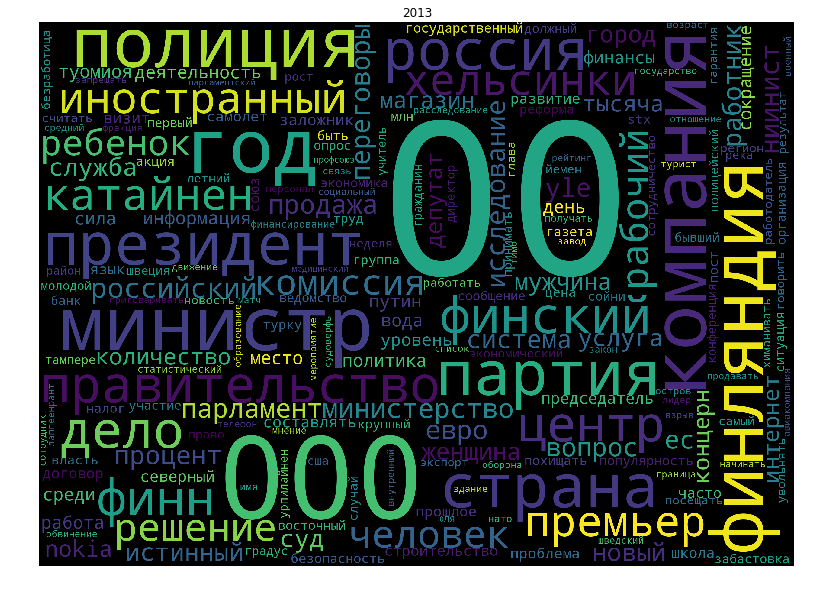

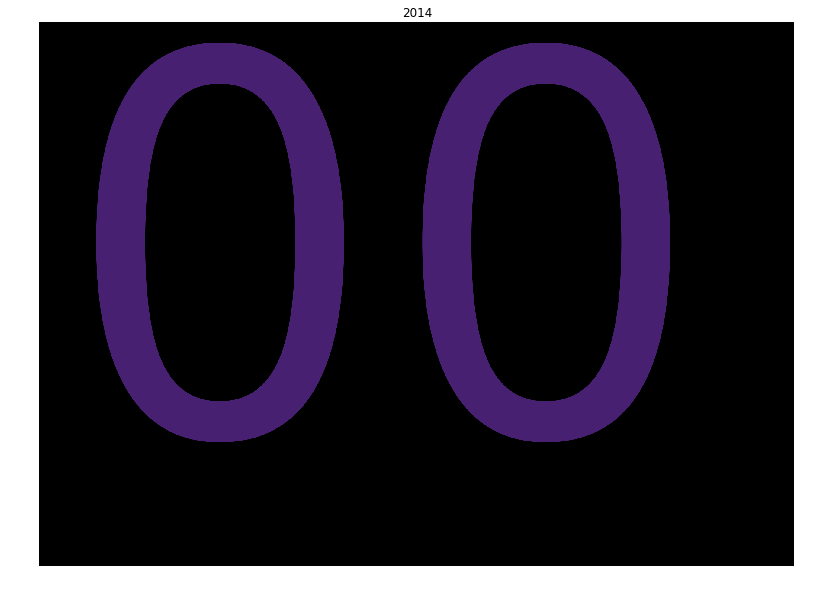

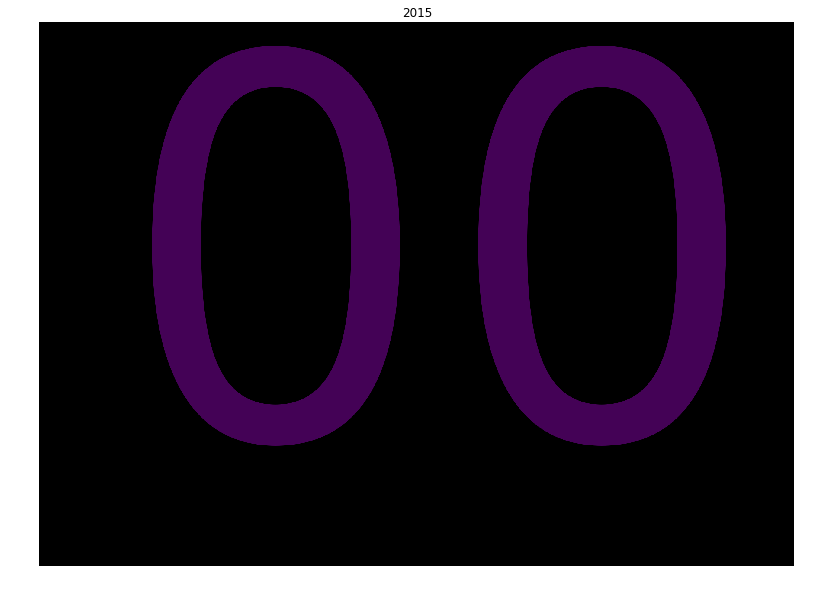

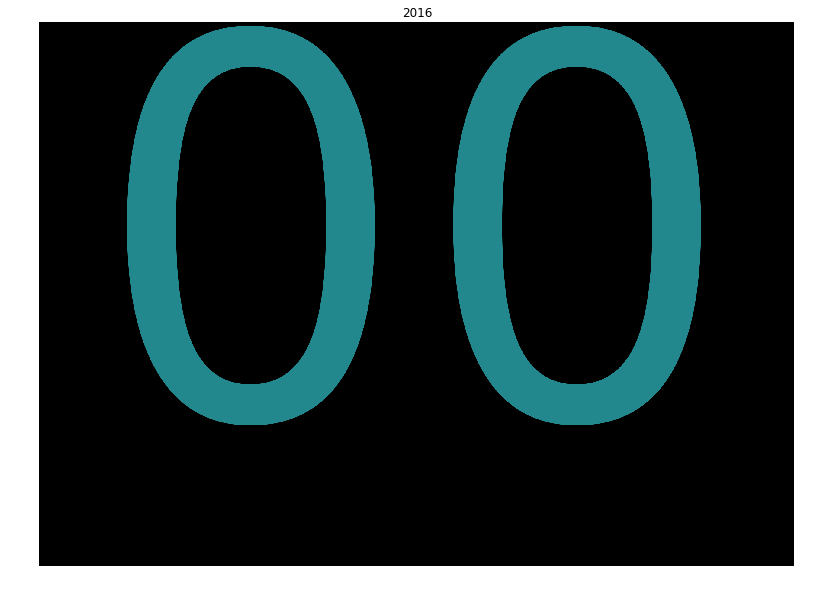

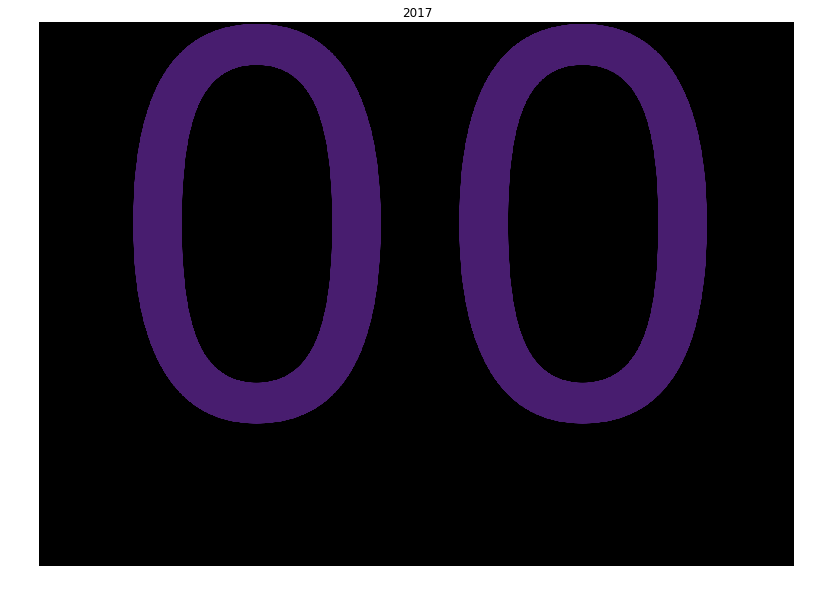

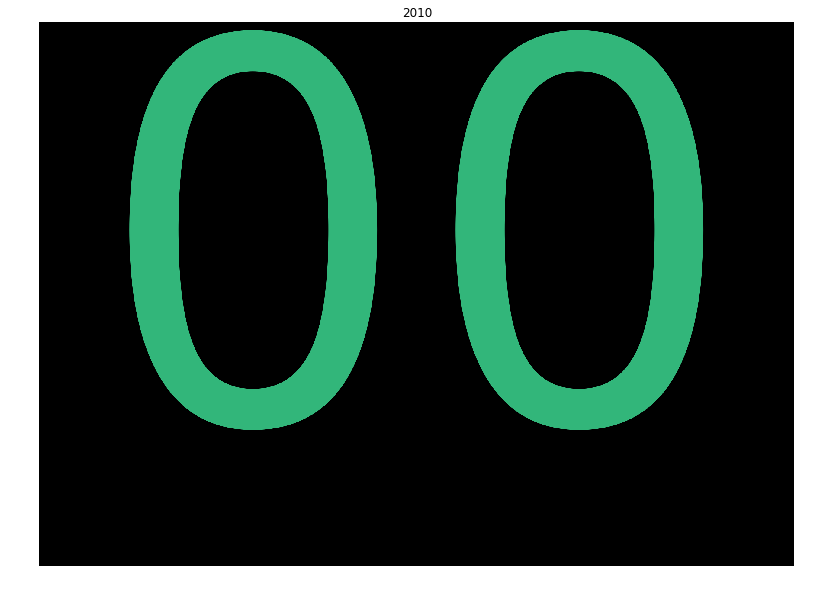

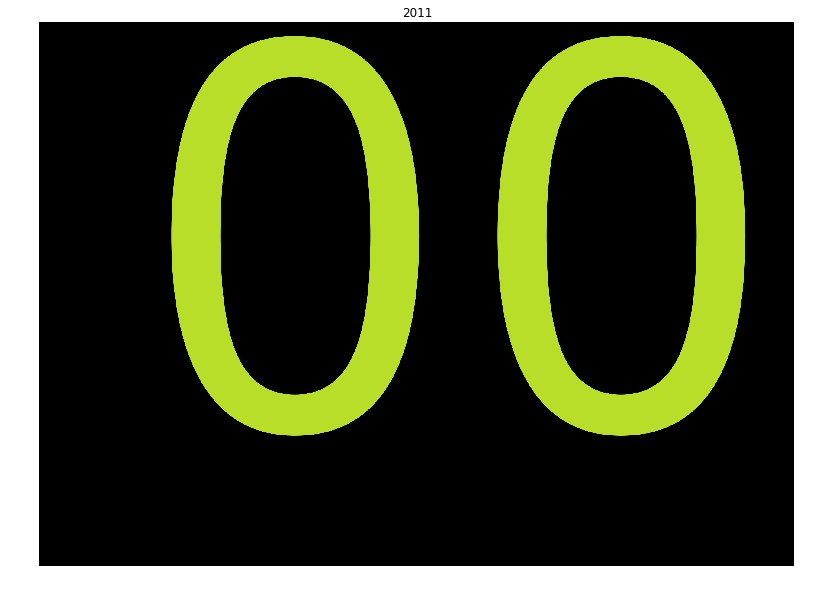

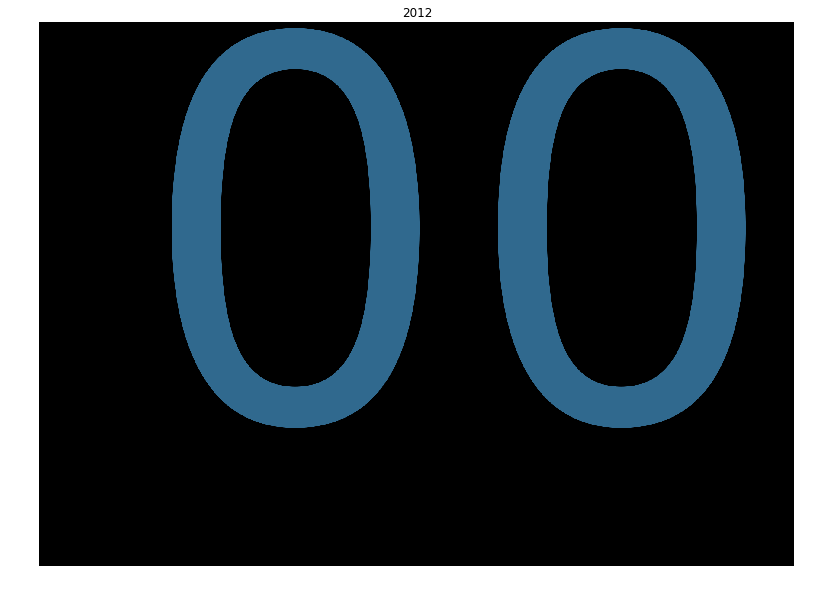

In [332]:
years = data['year'].unique()
for year in years:
    series = data.loc[data['year'] == year]['tfidf_top_words']
    counts = get_tf_idf_counts(series)
    output_wordcloud(counts, year)

In [ ]:
for year in sorted(years):
    print(year)

In [ ]:
# Output histograms of top words per year

In [338]:
data.loc[data['year'] == 2015]['tfidf_top_words']

7507     [00]
7508     [00]
7509     [00]
7510     [00]
7511     [00]
7512     [00]
7513     [00]
7514     [00]
7515     [00]
7516     [00]
7517     [00]
7518     [00]
7519     [00]
7520     [00]
7521     [00]
7522     [00]
7523     [00]
7524     [00]
7525     [00]
7526     [00]
7527     [00]
7528     [00]
7529     [00]
7530     [00]
7531     [00]
7532     [00]
7533     [00]
7534     [00]
7535     [00]
7536     [00]
         ... 
11754    [00]
11755    [00]
11756    [00]
11757    [00]
11758    [00]
11759    [00]
11760    [00]
11761    [00]
11762    [00]
11763    [00]
11764    [00]
11765    [00]
11766    [00]
11767    [00]
11768    [00]
11769    [00]
11770    [00]
11771    [00]
11772    [00]
11773    [00]
11774    [00]
11775    [00]
11776    [00]
11777    [00]
11778    [00]
11779    [00]
11780    [00]
11781    [00]
11782    [00]
11783    [00]
Name: tfidf_top_words, Length: 4277, dtype: object

In [330]:
sorted(years)

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [ ]:
# Target 2 - get a word cloud using TF-IDF for each year



# Target 3 - get a word cloud using TF-IDF for custom date range